In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from control.matlab import *
import slycot
from scipy import signal,io
import os
from scipy.linalg import fractional_matrix_power

# Python control toolbox available at https://python-control.readthedocs.io/

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})


In [20]:
q = 2   # Number of inputs
p = 2   # Number of outputs
n = 100 # State dimension
r = 10 # Reduced model order

testSys_mat = io.loadmat(os.path.join('..','DATA','testSys_ABCD.mat'))
A = testSys_mat['A']
B = testSys_mat['B']
C = testSys_mat['C']
D = testSys_mat['D']

sysFull = ss(A,B,C,D,1)

In [21]:
yFull = np.zeros((r*5+2,p,q))
tspan = np.arange(0,(r*5+2),1)
m = len(tspan)

for qi in range(q):
    yFull[:,:,qi],t = impulse(sysFull,T=tspan,input=qi)


YY = np.transpose(yFull,axes=(1,2,0)) # reorder to size p x q x m

In [85]:
## ERA and OKID Function Definitions

def ERA(YY,m,n,nin,nout,r):
    Dr = np.zeros((nout,nin))
    Y = np.zeros((nout,nin,YY.shape[2]-1))
    for i in range(nout):
        for j in range(nin):
            Dr[i,j] = YY[i,j,0]
            Y[i,j,:] = YY[i,j,1:]
            
    assert len(Y[:,1,1]) == nout
    assert len(Y[1,:,1]) == nin
    assert len(Y[1,1,:]) >= m+n
    
    H = np.zeros((nout*m,nin*n))
    H2 = np.zeros((nout*m,nin*n))
    
    for i in range(m):
        for j in range(n):
            for Q in range(nout):
                for P in range(nin):
                    H[nout*i+Q,nin*j+P] = Y[Q,P,i+j]
                    H2[nout*i+Q,nin*j+P] = Y[Q,P,i+j+1]
                    
    U,S,VT = np.linalg.svd(H,full_matrices=0)
    V = VT.T
    Sigma = np.diag(S[:r])
    Ur = U[:,:r]
    Vr = V[:,:r]
    Ar = fractional_matrix_power(Sigma,-0.5) @ Ur.T @ H2 @ Vr @ fractional_matrix_power(Sigma,-0.5)
    Br = fractional_matrix_power(Sigma,-0.5) @ Ur.T @ H[:,:nin]
    Cr = H[:nout,:] @ Vr @ fractional_matrix_power(Sigma,-0.5)
    HSVs = S
    
    return Ar,Br,Cr,Dr,HSVs

def OKID(y,u,r):
    # inputs:  y (sampled output), u (sampled input), r (effective system order)
    # outputs: H (Markov parameters), M (Observer gain)
    
    PP = y.shape[0] # number of outputs
    MM = y.shape[1] # number of output samples
    QQ = u.shape[0] # number of inputs
    lu = u.shape[1] # number of input samples
    
    assert MM == lu
    
    LL = r*5
    
    # Form data matrices y and V
    V = np.zeros((QQ+(QQ+PP)*LL,MM))
    for i in range(MM):
        V[:QQ,i] = u[:QQ,i]
        
    for i in range(1,LL+1):
        for j in range(MM-i):
            vtemp = np.concatenate((u[:,j],y[:,j]))
            V[QQ+(i-1)*(QQ+PP):QQ+i*(QQ+PP),i+j] = vtemp
    
    # Solve for observer Markov parameters Ybar
    Ybar = y @ np.linalg.pinv(V,rcond=10**(-3))
    
    # Isolate system Markov parameters H, and observer gain M
    D = Ybar[:,:QQ] # feed-through term (or D matrix) is the first term
    
    Y = np.zeros((PP,QQ,LL))
    Ybar1 = np.zeros((PP,QQ,LL))
    Ybar2 = np.zeros((PP,QQ,LL))
    
    for i in range(LL):
        Ybar1[:,:,i] = Ybar[:,QQ+(QQ+PP)*i : QQ+(QQ+PP)*i+QQ]
        Ybar2[:,:,i] = Ybar[:,QQ+(QQ+PP)*i+QQ : QQ+(QQ+PP)*(i+1)]
    
    Y[:,:,0] = Ybar1[:,:,0] + Ybar2[:,:,0] @ D
    for k in range(1,LL):
        Y[:,:,k] = Ybar1[:,:,k] + Ybar2[:,:,k] @ D
        for i in range(k-1):
            Y[:,:,k] += Ybar2[:,:,i] @ Y[:,:,k-i-1]
            
    H = np.zeros((D.shape[0],D.shape[1],LL+1))
    H[:,:,0] = D
    
    for k in range(1,LL+1):
        H[:,:,k] = Y[:,:,k-1]
        
    return H

In [41]:
## Compute ERA from impulse response
mco = int(np.floor((yFull.shape[0]-1)/2)) # m_c = m_o = (m-1)/2
Ar,Br,Cr,Dr,HSVs = ERA(YY,mco,mco,q,p,r)
sysERA = ss(Ar,Br,Cr,Dr,1)

In [58]:
## Compute random input simulation for OKID
uRandom = np.random.randn(q,200) # Random forcing input
yRandom = lsim(sysFull,uRandom,range(200))[0].T # Output

In [89]:
## Compute OKID and then ERA
H = OKID(yRandom,uRandom,r)
mco = int(np.floor((H.shape[2]-1)/2)) # m_c = m_o
Ar,Br,Cr,Dr,HSVs = ERA(H,mco,mco,q,p,r)
sysERAOKID = ss(Ar,Br,Cr,Dr,1)

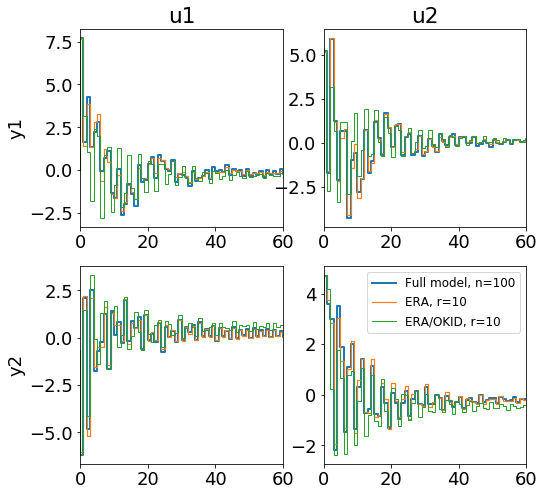

In [107]:
## Plot impulse responses for all methods

y1 = np.zeros((200,p,q))
y2 = np.zeros((100,p,q))
y3 = np.zeros((100,p,q))

for qi in range(q):
    y1[:,:,qi],t1 = impulse(sysFull,np.arange(200),input=qi)
    y2[:,:,qi],t2 = impulse(sysERA,np.arange(100),input=qi)
    y3[:,:,qi],t3 = impulse(sysERAOKID,np.arange(100),input=qi)

    


fig,axs = plt.subplots(2,2)
axs = axs.reshape(-1)

axs[0].step(t1,y1[:,0,0],linewidth=2)
axs[0].step(t2,y2[:,0,0],linewidth=1.2)
axs[0].step(t3,y3[:,0,0],linewidth=1)
axs[0].set_ylabel('y1')
axs[0].set_title('u1')

axs[1].step(t1,y1[:,0,1],linewidth=2)
axs[1].step(t2,y2[:,0,1],linewidth=1.2)
axs[1].step(t3,y3[:,0,1],linewidth=1)
axs[1].set_title('u2')

axs[2].step(t1,y1[:,1,0],linewidth=2)
axs[2].step(t2,y2[:,1,0],linewidth=1.2)
axs[2].step(t3,y3[:,1,0],linewidth=1)
axs[2].set_ylabel('y2')

axs[3].step(t1,y1[:,1,1],linewidth=2,label='Full model, n=100')
axs[3].step(t2,y2[:,1,1],linewidth=1.2,label='ERA, r={}'.format(r))
axs[3].step(t3,y3[:,1,1],linewidth=1,label='ERA/OKID, r={}'.format(r))
axs[3].legend(prop={'size': 12})

for ax in axs:
    ax.set_xlim(0,60)

plt.show()

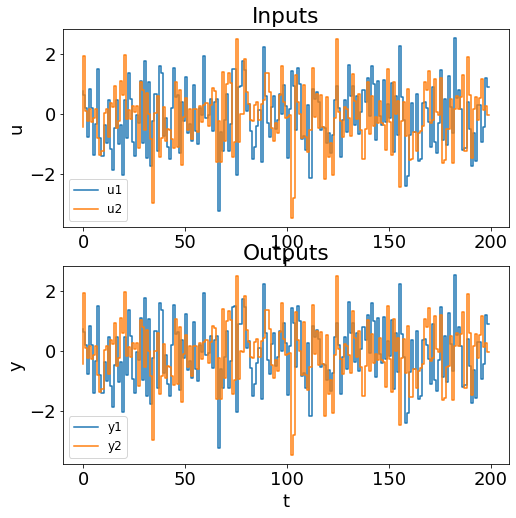

In [114]:
## Plot input/output pair for OKID
fig,axs = plt.subplots(2)

axs[0].set_title('Inputs')
axs[0].step(range(uRandom.shape[1]),uRandom[0,:],label='u1')
axs[0].step(range(uRandom.shape[1]),uRandom[1,:],label='u2')
axs[0].set_xlabel('t')
axs[0].set_ylabel('u')

axs[1].set_title('Outputs')
axs[1].step(range(yRandom.shape[1]),uRandom[0,:],label='y1')
axs[1].step(range(yRandom.shape[1]),uRandom[1,:],label='y2')
axs[1].set_xlabel('t')
axs[1].set_ylabel('y')

for ax in axs:
    ax.legend(prop={'size': 12})


plt.show()

In [108]:
uRandom.shape

(2, 200)